In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
import scipy.stats as ss
import csv
import numpy as np
import sklearn
import glob
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

C:\Users\ywen2\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Análisis:

**Carlos, Por favor, intenta escribir en estas celdas markdown, como si estuvieses escribiendo la memoria del TFG. De otra forma, llegará un momento en que no te acuerdes de lo que estás queriendo hacer. Es fundamental que vayas documentando todo lo que haces. Siento ser tan insistente sobre esto, pero es que es fundamental para poder terminar con un buen trabajo.**

Básicamente tienes que se capaz de contar lo que vamos a realizar. No es trabajo en vano, porque luego lo tienes que hacer en la memoria del TFG.

Todo lo que hicimos anteriormente para generar los conjuntos de entrenamiento y de test también deberías ir documentándolo, si no va a ser imposible que sólo revisando el código de acuerdes de todo y vas a perder mucho tiempo intentando entender que hacían las líneas de código.

Cargamos las matrices anteriormente creadas y que fueron divididas en train y test. Cargamos tanto los pacientes con sus variables y revisiones como las etiquetas asociadas a cada paciente

In [2]:
X_train = np.load('Conjunto_train.npy')
X_test = np.load('Conjunto_test.npy')
y_train = np.load('Labels_train.npy')
y_test = np.load('Labels_test.npy')

Comprobamos las dimensiones de cada matriz, tenemos 1317 pacientes para train y 330 para test (partición 80/20).

El 13 hace referencia al número de revisiones que nosotros mismos decicimos como idóneas. 22 son el número de features.

In [3]:
print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(1317,)
(1317, 13, 22)
(330,)
(330, 13, 22)


1º Comenzaremos con dos instantes temporales (nos será más fácil trabajar así, será extrapolable a cuando tengamos un mayor número de revisiones):

X_train_1[:,0,:] hace referencia al primer instante temporal (1º revisión), cogemos todos los pacientes y todas las features para ese primer instante.

X_train_1[:,1,:] hace referencia al segundo instante temporal (2º revisión), cogemos todos los pacientes y todas las features para ese segundo instante.

In [4]:
X_train_1 = X_train[:,0,:]
X_train_2 = X_train[:,1,:]

Como observamos el el histograma, los datos estás desbalanceados por lo que debemos aplicar oversampling (aumentando la clase minoritaria)

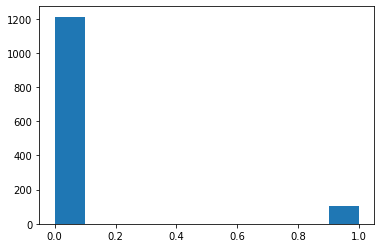

In [5]:
plt.hist(y_train)
plt.show()

No entiendo lo que haces aquí?? (en la celda que está debajo)

Hay que tratar los datos que tenemos a NaN, pero no podemos ponerlos símplemente a 0.

habría que hacer una función que nos permitiese tratar los NaNs. Vamos a hacer lo siguiente en la función:

1. Revisar si hay alguna característica que tenga más del 50% a NaN, entonces habría que considerar eliminarla. Tenemos un problema, porque hay que revisar que tengo más de 50% en todas las revisiones. Para no complicar las cosas, vamos a considerar que trabajamos sólo con tres revisiones (vamos a ver si llegamos rápido a ese punto, en otro caso deberíamos ver si paramos en tres revisiones, que ya es bastante).

1. Revisar si hay algún paciente con más de 8 características NaN, con que esto ocurra en cualquiera de las tres revisiones, deberíamos considerarlo que se elimina, en todas las revisiones.

## Features con problemas:

Revisando la información rápidamente hay varias features con problemas:

1. **Importante**: las variables *Blood_Glucose* y *Glycated-HB* hay que sacarlas fuera de la base de datos, porque son las que se utilizan para determinar si un pacientes diabético o no.
1. Hay cuatro variables que tiene muchos NaN, así que lo que intentaría sería centrarnos en cómo imputarlas, tanto en training como en test. Esto es un poco más complicado de lo que hacemos habitualmente con las bases de datos normales, porque aquí tenemos más datos y de forma un poco más complicada.
    * HOMA
    * Insulin
    * Vitamin-D
   
Estas son las que más tienen en las tres primeras revisiones. Lo que vamos a hacer es lo siguiente, aprovechando que tenemos un montón de datos y datos temporales vamos a utilizar un esquema diferente para hacer la imputación de forma que sea más razonable, intentando perder el menor número de datos posibles, por ejemplo: 
 * Regresión lineal múltiple con respecto a todas las variables temporales. Otra cosa
 * Verificar cuál es la correlación entre variables, para una misma revisión, y buscar con las que mayor correlación tengan y proponer un modelo de regresión lineal. 
 
Mi propuesta para el TFG: 
 * Vamos a hacer imputación por la mediana (en el caso de Vitamin-D, HOMA e Insulin) casi seguro que vamos a empeorar un poco porque hay muchos NaN, pero la esperanza es que todo se compense.
 * Si te ves con fuerzas y ganas probamos lo que he comentado anteriormente



In [6]:
feature_names = ['Age','Weight','Size','IMC','Creatinine','Cystatin','HDL','LDL','Triglyciredes','GOT','GPT','GGT','Albuminuria','Ferritin','HOMA','Insulin','Blood_Glucose','Glycated-HB','PCR','Vitamin-D','TAS','TAD','Date']
    
df = pd.DataFrame(X_train_1,columns = feature_names[:-1])

In [7]:
for index,value in enumerate (df.isnull().sum()):
        if value !=0:
            print(df.columns[index],value)

Weight 15
Size 6
IMC 19
Creatinine 21
Cystatin 263
HDL 115
LDL 135
Triglyciredes 24
GOT 198
GPT 26
GGT 54
Albuminuria 209
Ferritin 133
HOMA 958
Insulin 939
Blood_Glucose 27
Glycated-HB 740
PCR 231
Vitamin-D 1079


In [8]:
def data_nan_review_analysis(X):
    """
    Function that takes as input a matrix with pats and features for one review, and gets back
    X_train_rev_imputed,pats_to_drop,feature_to_drop,imputation_data
    """
    feature_names = ['Age','Weight','Size','IMC','Creatinine','Cystatin','HDL','LDL','Triglyciredes','GOT','GPT','GGT','Albuminuria','Ferritin','HOMA','Insulin','Blood_Glucose','Glycated-HB','PCR','Vitamin-D','TAS','TAD','Date']
    
    df = pd.DataFrame(X,columns = feature_names[:-1]) #convert it to df #delete date [:-1]
    
    print(df.columns)
    df = df.drop('Blood_Glucose',axis = 1)
    df = df.drop('Glycated-HB',axis = 1)
    
    
    #initialize vars to return
    X_train_rev_imputed = []
    pats_to_drop = []
    feature_to_drop = []
    imputation_data = []
    #check number of NaNs per feature
    
    for index,value in enumerate (df.isnull().sum()):
        if value !=0:
            print(df.columns[index],value)
            
    #Drop features: Blood_Glucose and Glycated_HB
    

    ##reemplazar cada valor por la mediana 
    
    X_train_rev_imputed = df.fillna(df.median()) 
    
    return X_train_rev_imputed,pats_to_drop,feature_to_drop,imputation_data

def imputing_data(X):
    """ 
    Function that check data with nans and replace them with appropriate imputation
    """
    X_train_aux = X_train.copy()
    num_review = X_train_aux.shape[1]
    
    X_train_imp = []
    
    #run over the reviews and get the X_train_imputed, pats_to_drop, feature_to_drop, and imputation values
    for i in range(3):
        print("review",i)
        print("----------")
        X_train_rev_imputed,pats_to_drop,feature_to_drop,imputation_data = data_nan_review_analysis(X_train_aux[:,i,:])
        print("----------")
        print("----------")
        
        X_train_imp.append(X_train_rev_imputed)
        
    return X_train_imp

Creamos una nueva variable: **X_train_imp**, obtenida de aplicar la función imputing_data a X_train. Devuelve lo siguiente

- Nº de revisión
- Features
- Features con sus respectivos NaN (no aparecen las features eliminadas previamente por la función)

In [9]:
X_train_imp = imputing_data(X_train)

review 0
----------
Index(['Age', 'Weight', 'Size', 'IMC', 'Creatinine', 'Cystatin', 'HDL', 'LDL',
       'Triglyciredes', 'GOT', 'GPT', 'GGT', 'Albuminuria', 'Ferritin', 'HOMA',
       'Insulin', 'Blood_Glucose', 'Glycated-HB', 'PCR', 'Vitamin-D', 'TAS',
       'TAD'],
      dtype='object')
Weight 15
Size 6
IMC 19
Creatinine 21
Cystatin 263
HDL 115
LDL 135
Triglyciredes 24
GOT 198
GPT 26
GGT 54
Albuminuria 209
Ferritin 133
HOMA 958
Insulin 939
PCR 231
Vitamin-D 1079
----------
----------
review 1
----------
Index(['Age', 'Weight', 'Size', 'IMC', 'Creatinine', 'Cystatin', 'HDL', 'LDL',
       'Triglyciredes', 'GOT', 'GPT', 'GGT', 'Albuminuria', 'Ferritin', 'HOMA',
       'Insulin', 'Blood_Glucose', 'Glycated-HB', 'PCR', 'Vitamin-D', 'TAS',
       'TAD'],
      dtype='object')
Age 2
Weight 13
Size 4
IMC 15
Creatinine 5
Cystatin 141
HDL 100
LDL 119
Triglyciredes 8
GOT 200
GPT 8
GGT 35
Albuminuria 166
Ferritin 81
HOMA 919
Insulin 903
PCR 132
Vitamin-D 993
----------
----------
review 2
--

In [10]:
#review imputed data #Values for Revision 1 for vitamin D
X_train_imp[1]['Vitamin-D']

0       28.0
1       28.0
2       28.0
3       28.0
4       28.0
        ... 
1312    28.0
1313    28.0
1314    28.0
1315    28.0
1316    19.0
Name: Vitamin-D, Length: 1317, dtype: float64

Obtenemos las **dos primeras revisiones** ya que nos es más sencillo trabajar. El resultado obtenido será extrapolable a un mayor número de revisiones.

In [11]:
#Get the two first reviews

X_train_1 = X_train_imp[0]
X_train_2 = X_train_imp[1]

### Oversampling:

Este método utiliza la generación de datos sintéticos para aumentar el número de muestras en el conjunto de datos.
Objetivo: aumentar la clase minoritaria para que el conjunto de datos se equilibre mediante la creación de observaciones sintéticas basadas en las observaciones minoritarias existentes.

In [13]:
from imblearn.over_sampling import ADASYN

**ADASYN** es una versión mejorada de Smote. Lo que hace es igual que SMOTE pero con una pequeña mejora. Después de crear esa muestra, agrega pequeños valores aleatorios a los puntos, lo que la hace más realista. En otras palabras, en lugar de que toda la muestra se correlacione linealmente con el punto vecino, tienen un poco más de varianza, es decir, están un poco dispersas.

In [14]:
X_train_adasyn,y_train_adasyn = ADASYN(n_neighbors = 11).fit_resample(X_train_1,y_train)
counter = sorted(Counter(y_train_adasyn).items())
print(sorted(Counter(y_train_adasyn).items()))

[(0, 1212), (1, 1248)]


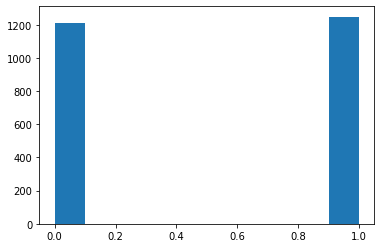

In [15]:
plt.hist(y_train_adasyn)
plt.show()

### Random Forest

Para ver los hiperparámetros disponibles, podemos crear un bosque aleatorio y examinar los valores predeterminados.

In [ ]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(rf.get_params())

Debemos probar una amplia gama de valores y ver qué funciona. Intentaremos ajustar el siguiente conjunto de hiperparámetros:

- max_features = max number of features considered for splitting a node
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node

Para usar **RandomizedSearchCV**, primero necesitamos crear una cuadrícula de parámetros para muestrear durante el ajuste:

In [16]:
from sklearn.model_selection import RandomizedSearchCV
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,8,10,12,14,16,18,20]
# Create the random grid
random_grid = {'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,}
print(random_grid)

{'max_features': ['auto', 'sqrt', 'log2'], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 8, 10, 12, 14, 16, 18, 20]}


En cada iteración, el algoritmo elegirá una combinación diferente de las características. El beneficio de una búsqueda aleatoria es que no probamos todas las combinaciones, sino que seleccionamos al azar para muestrear una amplia gama de valores.

**Grid Search**
- cv, que es el número de pliegues que se deben usar para la validación cruzada. 

Más pliegues de cv reducen las posibilidades de sobreajuste, pero aumentarlo aumentará el tiempo de ejecución.

In [17]:
# First create the base model to tune
rf_1 = RandomForestClassifier(n_estimators=100, criterion='gini',  
                   bootstrap=True, oob_score=False, class_weight = 'balanced_subsample')

In [18]:
from sklearn.model_selection import GridSearchCV
# Use the random grid to search for best hyperparameters
# Grid search of parameters, using 7 fold cross validation,

grid_random = GridSearchCV(rf_1, random_grid, cv=7 , n_jobs = -1, verbose = 5)

In [19]:
# Fit the random search model
grid_random.fit(X_train_adasyn, y_train_adasyn)

Fitting 7 folds for each of 90 candidates, totalling 630 fits


GridSearchCV(cv=7,
             estimator=RandomForestClassifier(class_weight='balanced_subsample'),
             n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4, 8, 10, 12, 14, 16, 18,
                                              20],
                         'min_samples_split': [2, 5, 10]},
             verbose=5)

In [20]:
grid_random.best_params_

{'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}

Creamos un **nuevo modelo** teniendo en cuenta los hiperparámetros que nos devuelve Grid_Search

In [21]:
rf_2 = RandomForestClassifier(n_estimators=5000, criterion='gini', max_features = grid_random.best_params_['max_features'],
                min_samples_leaf = grid_random.best_params_['min_samples_leaf'], min_samples_split = grid_random.best_params_['min_samples_split'],    
                   bootstrap=True, oob_score=False, class_weight = 'balanced_subsample')

In [22]:
rf_2.fit(X_train_adasyn, y_train_adasyn)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5000)

In [23]:
y_pred = rf_2.predict(X_train_adasyn)
print(y_pred)

[0 1 0 ... 1 1 1]


### Prestaciones

In [31]:
def prestaciones(confusion):
    tasa_acierto = (confusion[0][0] + confusion[1][1])/(confusion[0][0] + confusion[0][1]+confusion[1][0] + confusion[1][1])
    sensibilidad = (confusion[1][1])/(confusion[0][1] + confusion[1][1])
    especificidad = (confusion[0][0] )/(confusion[0][0] + confusion[0][1])    
    precision = (confusion[1][1])/(confusion[1][0] + confusion[1][1])
     
    print('Tasa acierto: ' + str(tasa_acierto) + '\033[1m' + ',Sensibilidad: ' + str(sensibilidad)  + '\033[0m'+ ' Especificidad: ' + str(especificidad) +'\033[1m' + ',Precision: ' + str(precision) + '\033[0m')

In [24]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

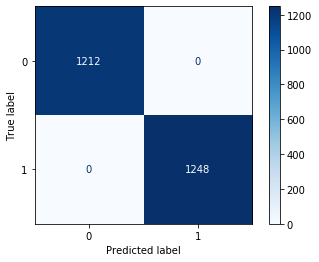

Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0


In [25]:
#cm = confusion_matrix(y_train_adasyn,y_pred)
cm = confusion_matrix(y_train_adasyn,y_pred)

#plot_confusion_matrix(rf_1,X_train_adasyn,y_train_adasyn,cmap=plt.cm.Blues)
plot_confusion_matrix(rf_2,X_train_adasyn,y_train_adasyn,cmap=plt.cm.Blues)

plt.show()

#sensibilidad y especificidad
total1=sum(sum(cm))
#####from confusion matrix calculate accuracy
accuracy1=(cm[0,0]+cm[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity : ', specificity1)

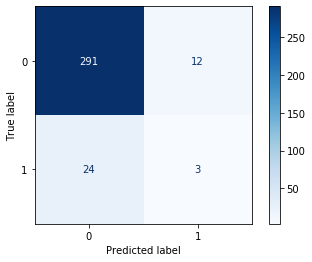

In [27]:
#modify NaNs in X_test

feature_names = ['Age','Weight','Size','IMC','Creatinine','Cystatin','HDL','LDL','Triglyciredes','GOT','GPT','GGT','Albuminuria','Ferritin','HOMA','Insulin','Blood_Glucose','Glycated-HB','PCR','Vitamin-D','TAS','TAD','Date']

X_test_1 = pd.DataFrame(X_test[:,0,:],columns = feature_names[:-1])

X_test_1 = X_test_1.drop('Blood_Glucose',axis = 1)
X_test_1 = X_test_1.drop('Glycated-HB',axis = 1)

#impute

X_test_1 = X_test_1.fillna(X_train_1.median())

y_pred_test = rf_2.predict(X_test_1)

plot_confusion_matrix(rf_2,X_test_1,y_test,cmap=plt.cm.Blues)

plt.show()

In [32]:
cm1 = confusion_matrix(y_pred_test,y_test)
print(prestaciones(cm_1))
total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

Tasa acierto: 0.8909090909090909,Sensibilidad: 0.1111111111111111 Especificidad: 0.9238095238095239,Precision: 0.2
None
Accuracy :  0.8909090909090909
Sensitivity :  0.9238095238095239
Specificity :  83.2


### Aplicamos el modelo eliminando los variables Vitamin-D, HOMA e Insulin

In [ ]:
def data_nan_review_analysis_1(X):
    """
    Function that takes as input a matrix with pats and features for one review, and gets back
    X_train_rev_imputed,pats_to_drop,feature_to_drop,imputation_data
    """
    feature_names = ['Age','Weight','Size','IMC','Creatinine','Cystatin','HDL','LDL','Triglyciredes','GOT','GPT','GGT','Albuminuria','Ferritin','HOMA','Insulin','Blood_Glucose','Glycated-HB','PCR','Vitamin-D','TAS','TAD','Date']
    
    df = pd.DataFrame(X,columns = feature_names[:-1]) #convert it to df #delete date [:-1]
    
    print(df.columns)
    df = df.drop('HOMA',axis = 1)
    df = df.drop('Insulin',axis = 1)
    df = df.drop('Blood_Glucose',axis = 1)
    df = df.drop('Glycated-HB',axis = 1)
    df = df.drop('Vitamin-D',axis = 1)
    
    
    
    #initialize vars to return
    X_train_rev_imputed = []
    pats_to_drop = []
    feature_to_drop = []
    imputation_data = []
    #check number of NaNs per feature
    
    for index,value in enumerate (df.isnull().sum()):
        if value !=0:
            print(df.columns[index],value)
            
    #Drop features: Blood_Glucose and Glycated_HB
    

    ##reemplazar cada valor por la mediana 
    
    X_train_rev_imputed = df.fillna(df.median()) 
    
    return X_train_rev_imputed,pats_to_drop,feature_to_drop,imputation_data

def imputing_data_1(X):
    """ 
    Function that check data with nans and replace them with appropriate imputation
    """
    X_train_aux = X_train.copy()
    num_review = X_train_aux.shape[1]
    
    X_train_imp = []
    
    #run over the reviews and get the X_train_imputed, pats_to_drop, feature_to_drop, and imputation values
    for i in range(3):
        print("review",i)
        print("----------")
        X_train_rev_imputed,pats_to_drop,feature_to_drop,imputation_data = data_nan_review_analysis_1(X_train_aux[:,i,:])
        print("----------")
        print("----------")
        
        X_train_imp.append(X_train_rev_imputed)
        
    return X_train_imp

In [ ]:
X_train_imp_1 = imputing_data_1(X_train)

In [ ]:
#Get the two first reviews

X_train_1 = X_train_imp_1[0]
X_train_2 = X_train_imp_1[1]

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN

X_train_adasyn_1,y_train_adasyn_1 = ADASYN(n_neighbors = 11).fit_resample(X_train_1,y_train)
print(sorted(Counter(y_train_adasyn_1).items()))

In [ ]:
rf_1 = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=2, min_samples_leaf=1, 
                    max_features='auto', bootstrap=True, oob_score=True,class_weight = 'balanced_subsample')

In [ ]:
rf_1.fit(X_train_adasyn_1, y_train_adasyn_1)

In [ ]:
y_pred = rf_1.predict(X_train_adasyn_1)

print(y_pred)

In [ ]:
cm = confusion_matrix(y_train_adasyn_1,y_pred)

plot_confusion_matrix(rf_1,X_train_adasyn_1,y_train_adasyn_1,cmap=plt.cm.Blues)

plt.show()

In [ ]:
#modify NaNs in X_test

feature_names = ['Age','Weight','Size','IMC','Creatinine','Cystatin','HDL','LDL','Triglyciredes','GOT','GPT','GGT','Albuminuria','Ferritin','HOMA','Insulin','Blood_Glucose','Glycated-HB','PCR','Vitamin-D','TAS','TAD','Date']

X_test_1 = pd.DataFrame(X_test[:,0,:],columns = feature_names[:-1])


X_test_1 = X_test_1.drop('Blood_Glucose',axis = 1)
X_test_1 = X_test_1.drop('Glycated-HB',axis = 1)
X_test_1 = X_test_1.drop('HOMA',axis = 1)
X_test_1 = X_test_1.drop('Insulin',axis = 1)
X_test_1 = X_test_1.drop('Vitamin-D',axis = 1)



#impute

X_test_1 = X_test_1.fillna(X_train_1.median())

y_pred_test = rf_1.predict(X_test_1)

plot_confusion_matrix(rf_1,X_test_1,y_test,cmap=plt.cm.Blues)

plt.show()

## Cosas que faltarían por hacer

1. Habría que hacer una búsqueda de hiperparámetros utilizando oob score, sobre los parámetros que hablamos el otro día.
1. Habría que comparar los resultados con la otra técnica de hacer oversampling. Quizá convendría utilizar alguna técnica diferente como undersampling, me parece que los resultados van a estar superajustados en otro caso.
1. Hacer un calibrado de la probabilidad de predicción.
1. Yo haría una prueba eliminando las variables: Vitamin-D, HOMA, Insulin y ver que sale sin ellas.